# Aside Training VAE

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [4]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [15]:
batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
          transform=transforms.ToTensor(),
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [83]:
device = torch.device('cuda: 0' if torch.cuda.is_available() else 'cpu')

In [100]:
d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid()
        )
        
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [101]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

In [102]:
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return BCE + KLD

====> Test set loss: 104.4007
====> Epoch: 1 Average loss: 113.1762
====> Test set loss: 102.4254
====> Epoch: 2 Average loss: 111.3905
====> Test set loss: 101.6983
====> Epoch: 3 Average loss: 110.0624
====> Test set loss: 100.0870
====> Epoch: 4 Average loss: 109.1528
====> Test set loss: 98.9074
====> Epoch: 5 Average loss: 108.3705
====> Test set loss: 98.8519
====> Epoch: 6 Average loss: 107.7706
====> Test set loss: 98.2176
====> Epoch: 7 Average loss: 107.2082
====> Test set loss: 98.1369
====> Epoch: 8 Average loss: 106.7378
====> Test set loss: 97.5843
====> Epoch: 9 Average loss: 106.4194
====> Test set loss: 97.5901
====> Epoch: 10 Average loss: 106.0420
====> Test set loss: 96.6971


<ipython-input-2-a5f471b0cdc3>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))


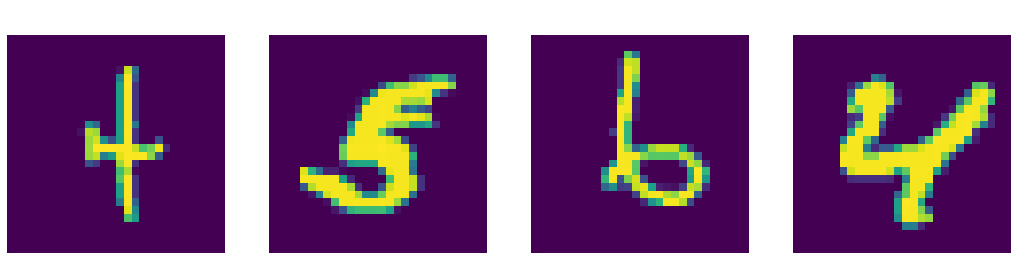

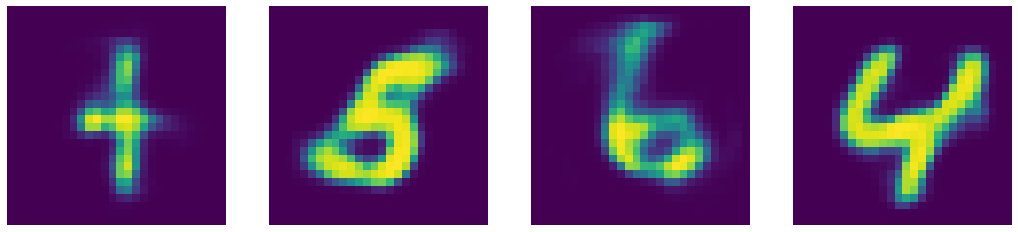

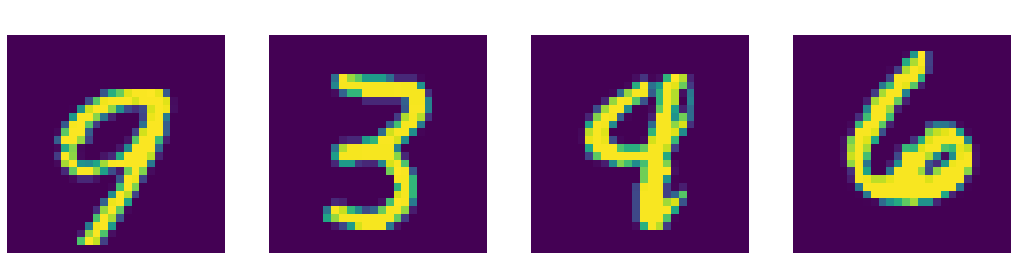

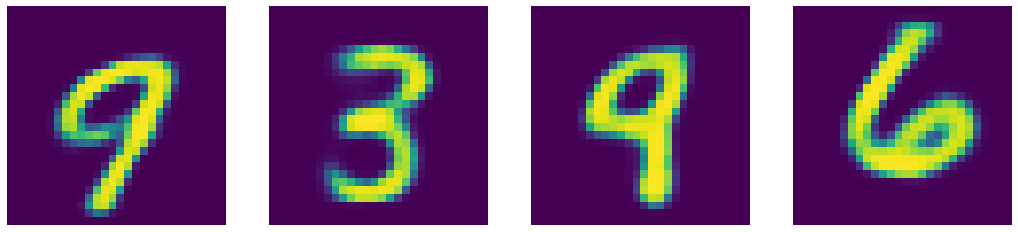

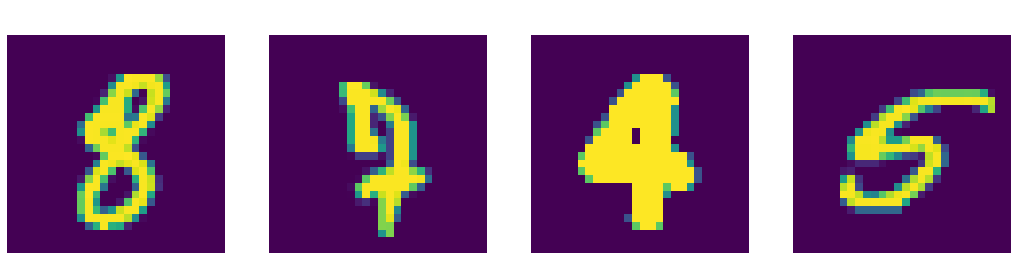

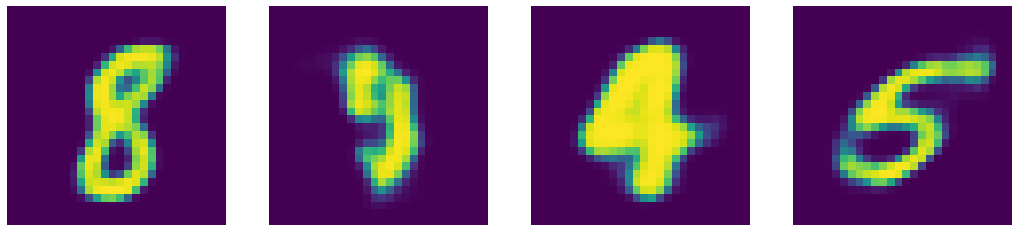

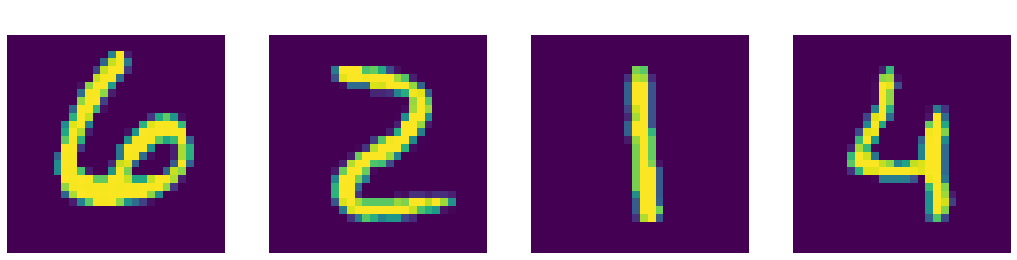

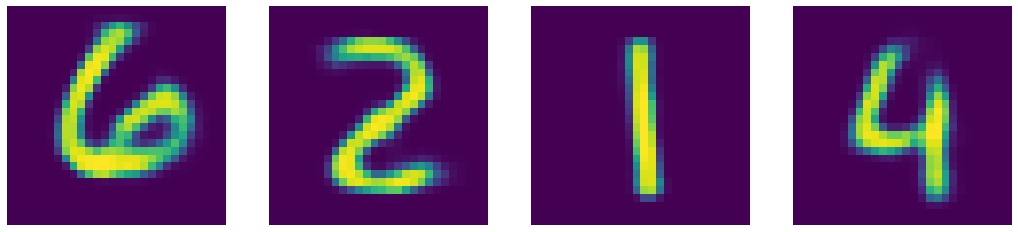

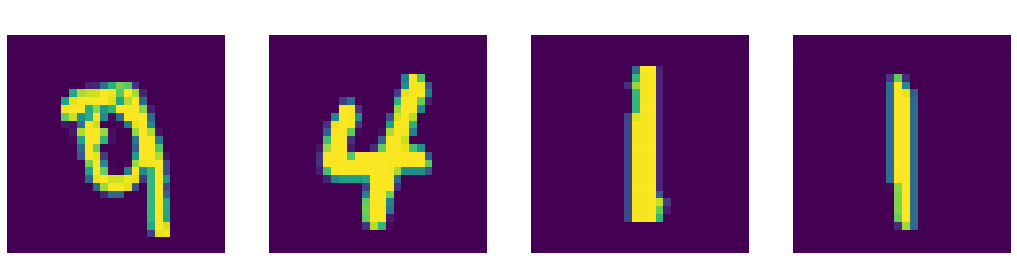

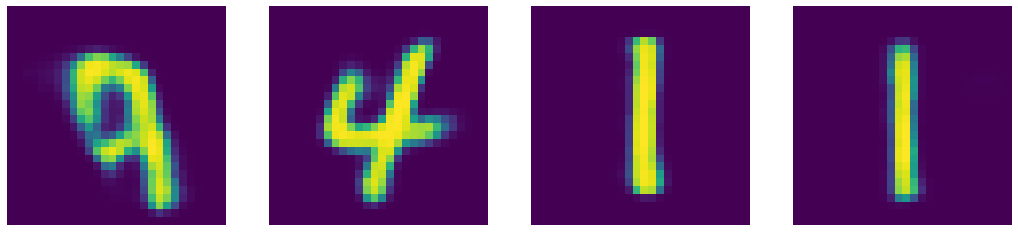

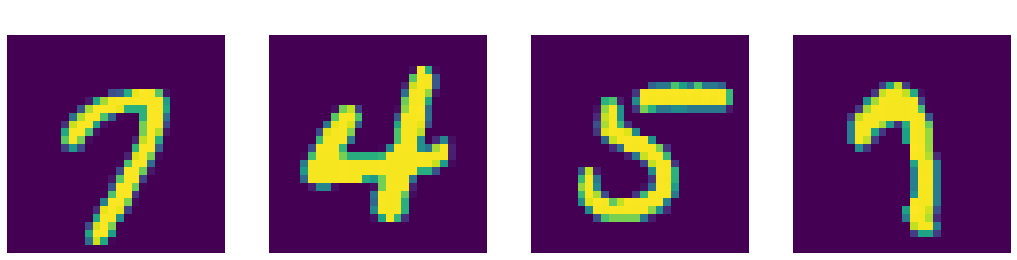

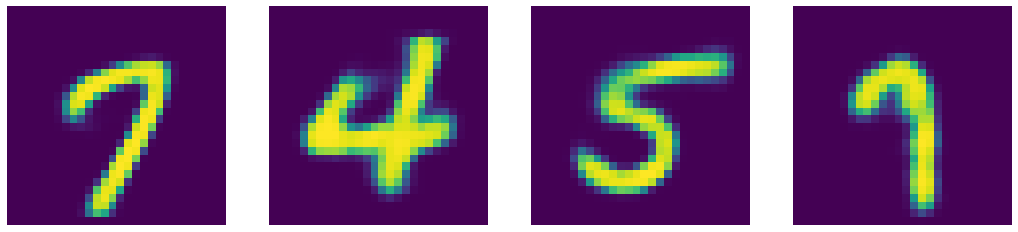

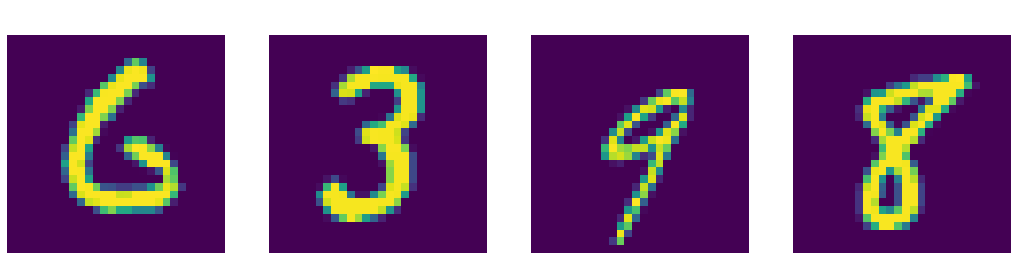

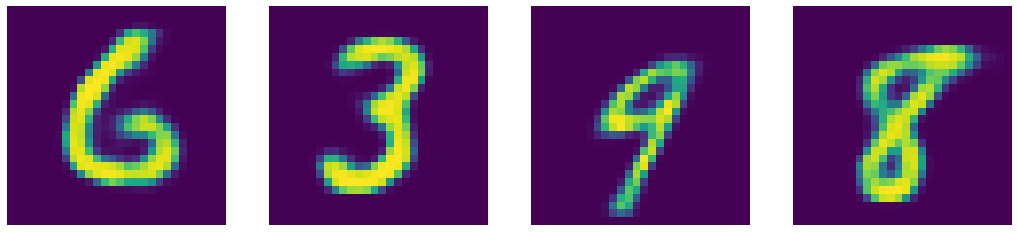

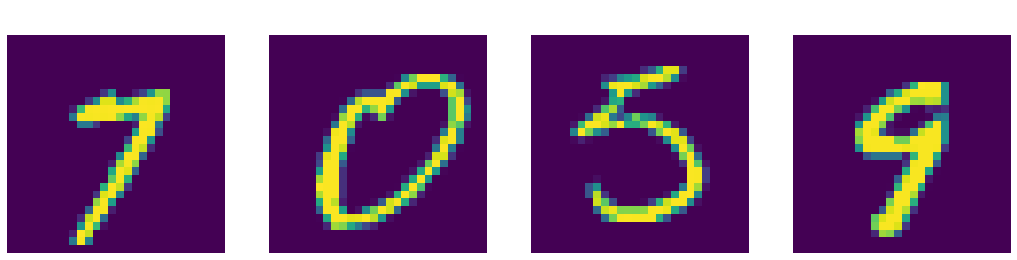

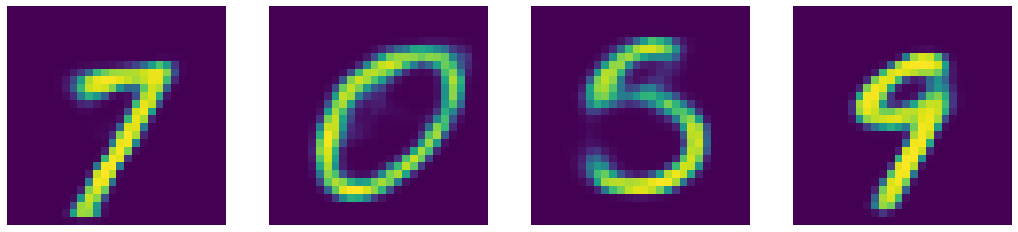

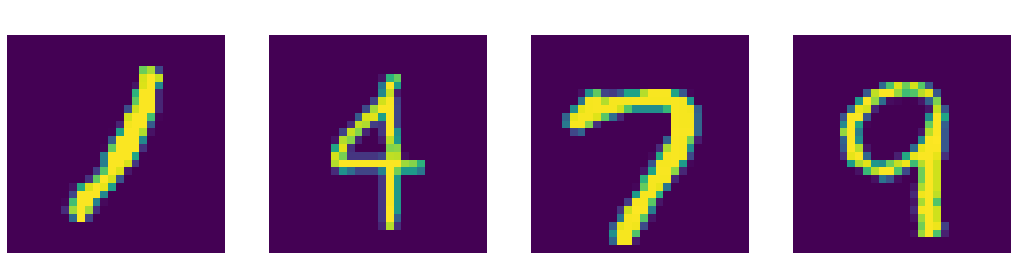

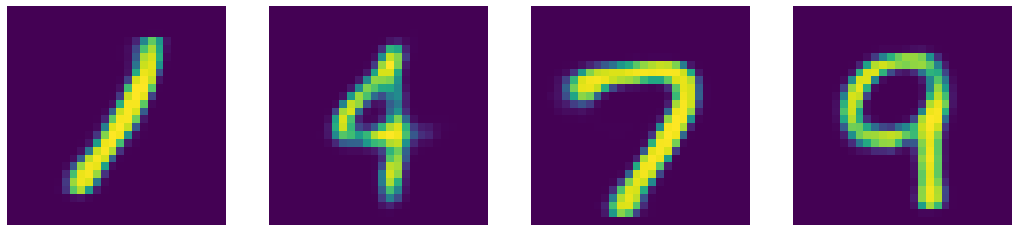

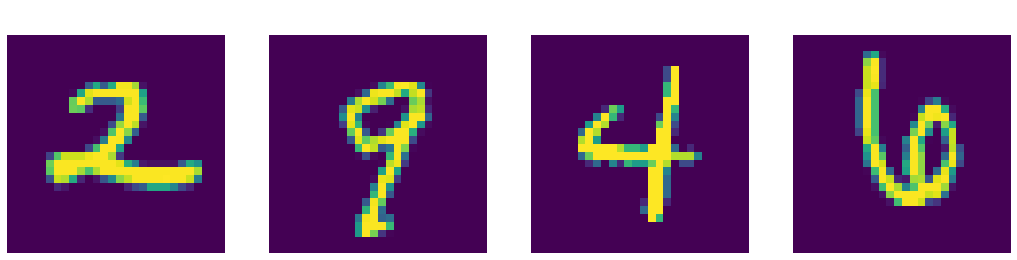

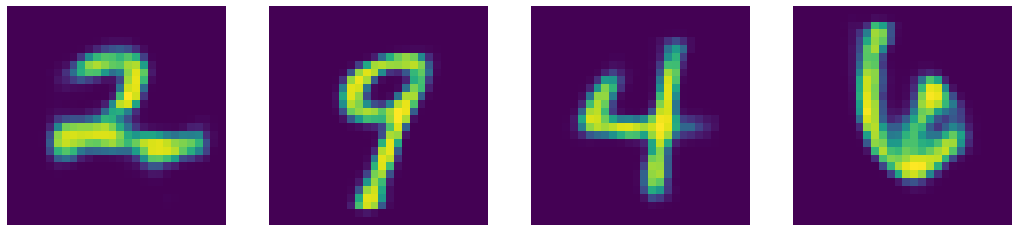

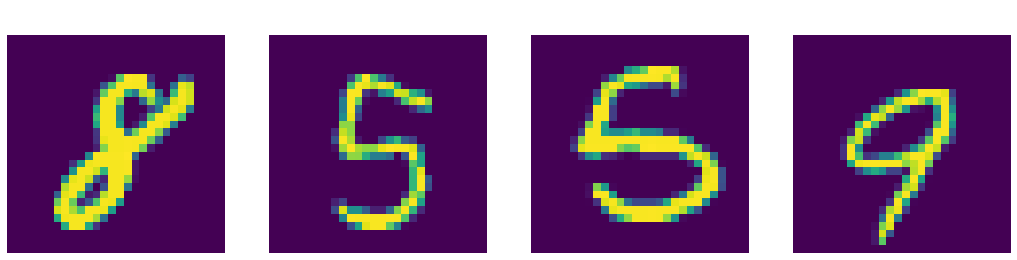

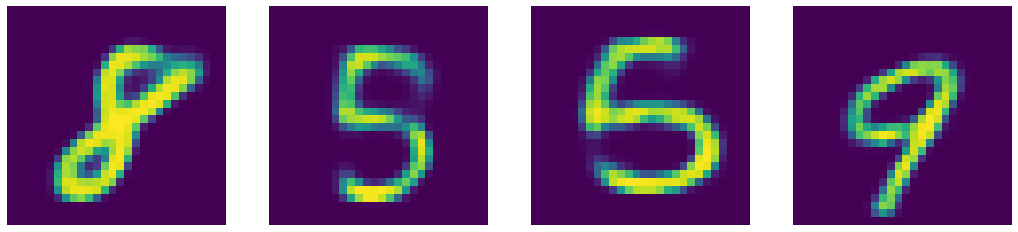

In [104]:
epochs = 10
codes = dict(mu=list(), logvar=list(), y=list())
for epoch in range(0, epochs + 1):
    if epoch > 0: # inspect untrained net
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            
            # ======== forward ======== 
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ======== backward ======== 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # forward
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            
            # log
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    codes['mu'].append(torch.cat(means))
    codes['logvar'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

In [130]:
model.decoder

Sequential(
  (0): Linear(in_features=20, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=784, bias=True)
  (3): Sigmoid()
)

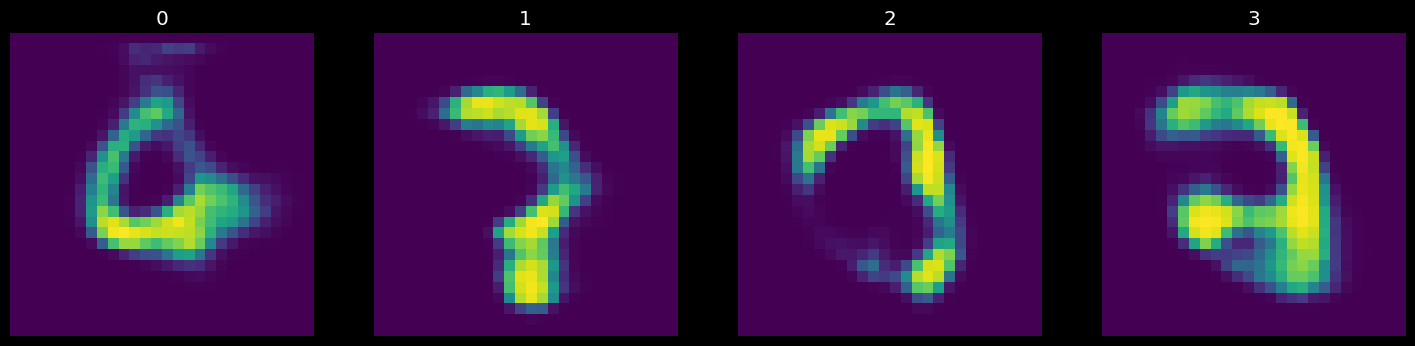

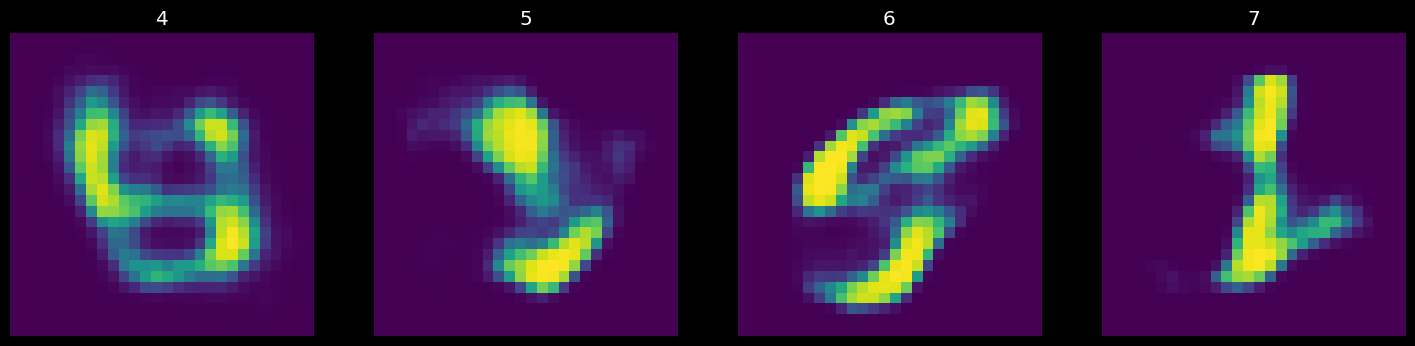

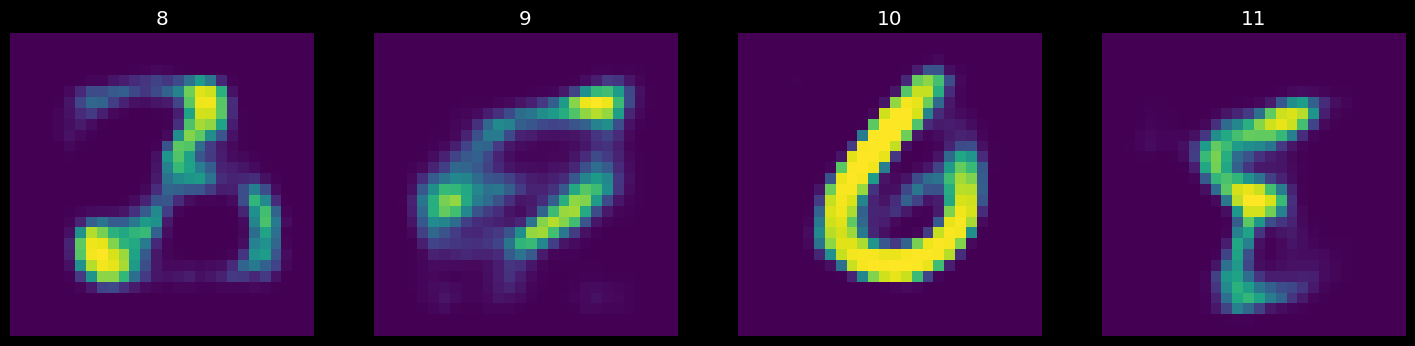

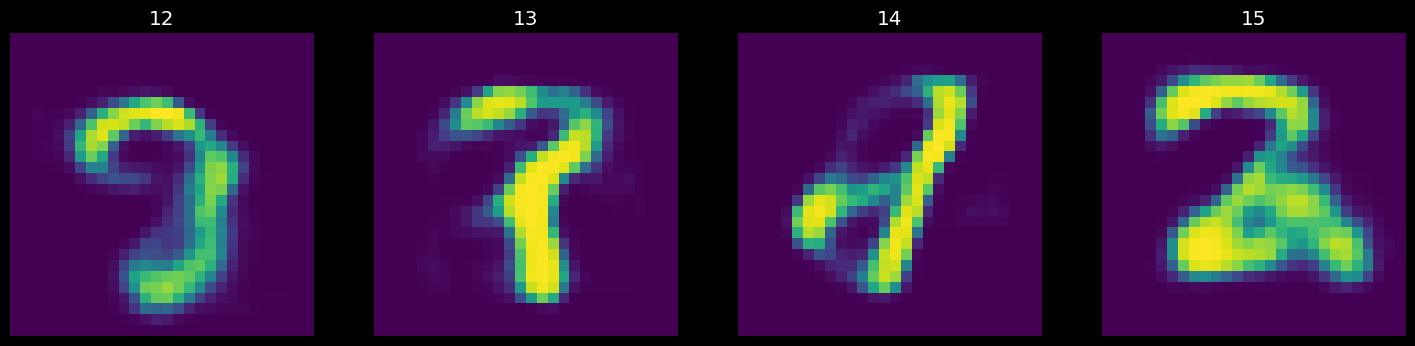

In [126]:
# Generating samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

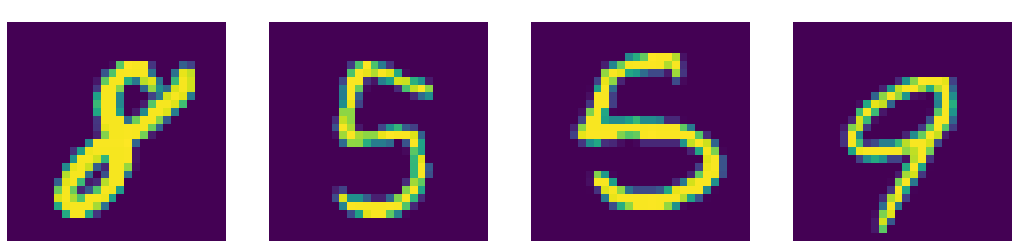

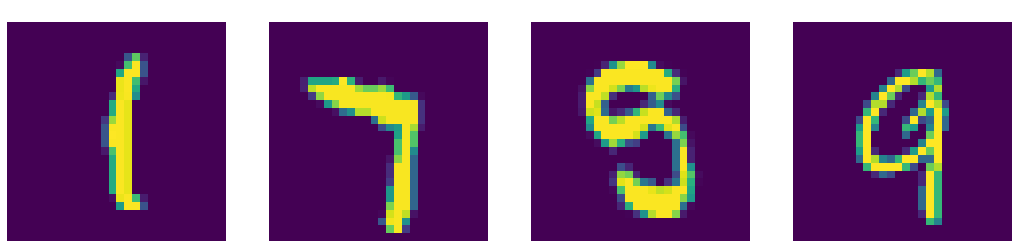

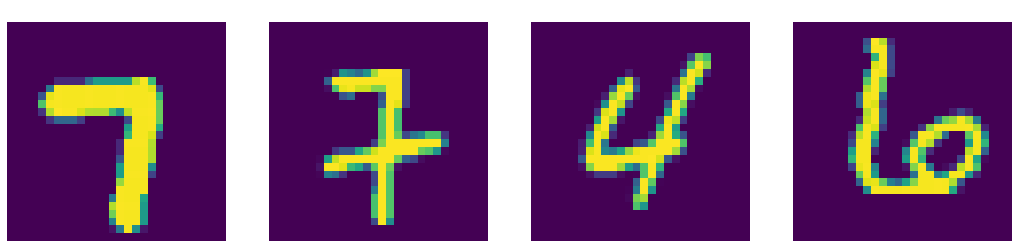

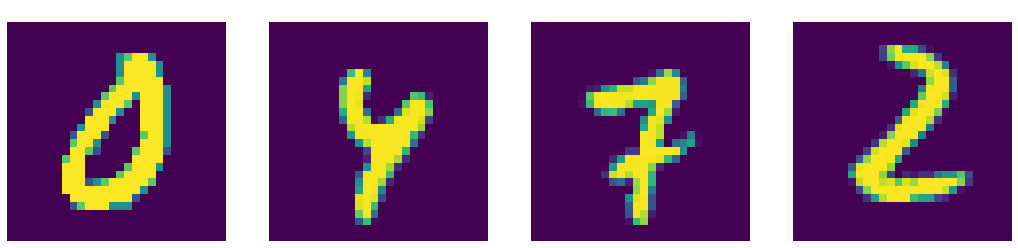

In [110]:
# display last test batch
display_images(None, x, 4, count=True)

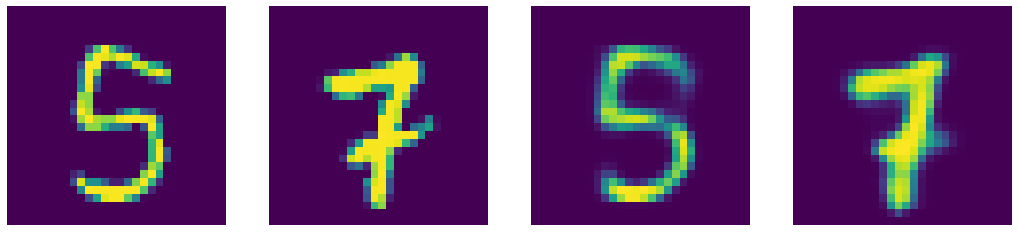

In [114]:
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

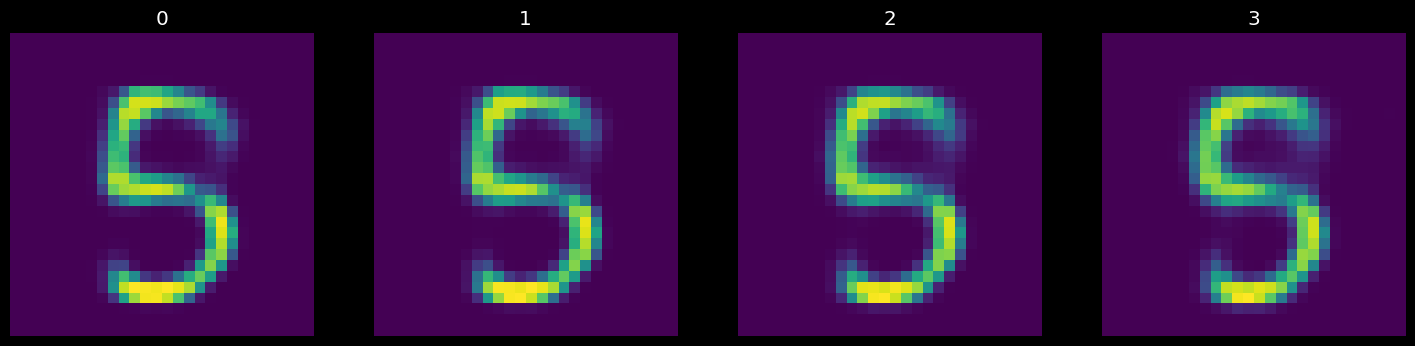

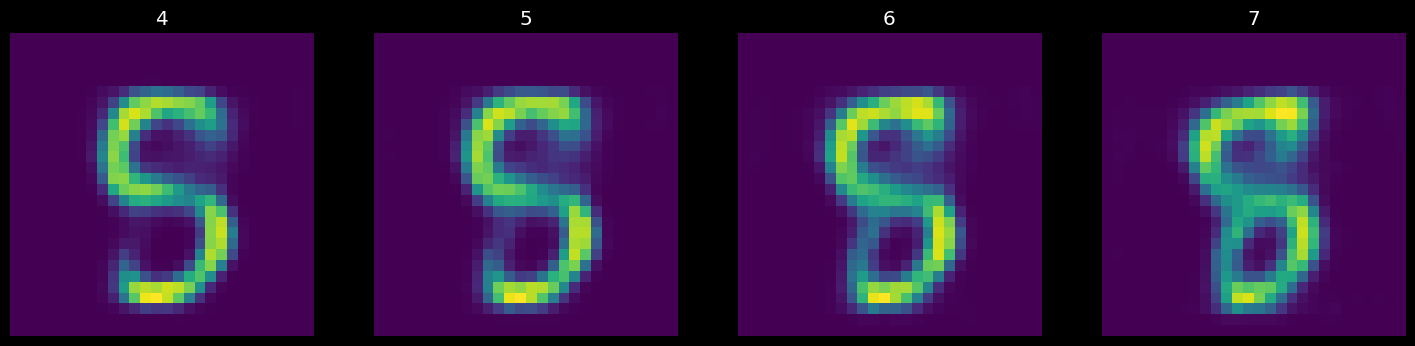

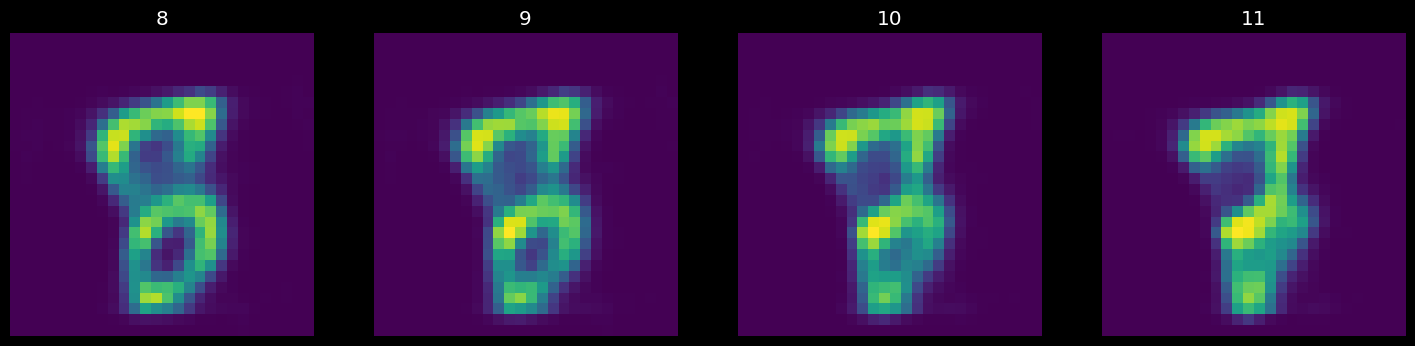

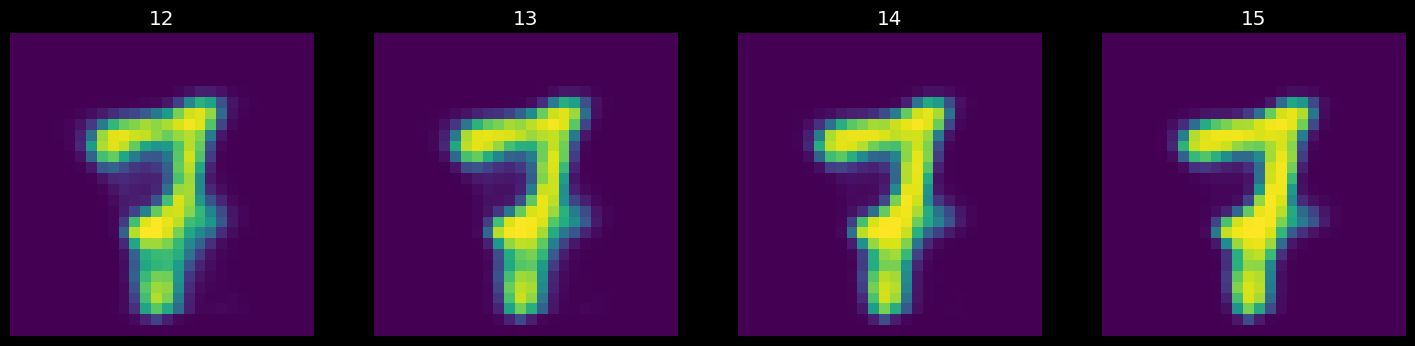

In [136]:
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    
sample = model.decoder(code)    
display_images(None, sample, N // 4, count=True)

In [117]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

In [118]:
set_default(figsize=(15, 4))

In [124]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000
epochs = (0, 3, 10)
for epoch in epochs:
    X.append(codes['mu'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

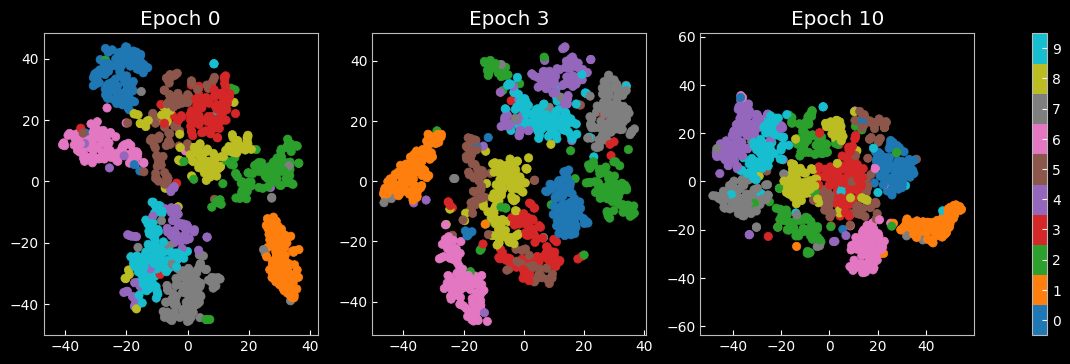

In [125]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:, 0], E[i][:, 1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

### Aside: examine KL - Divergence

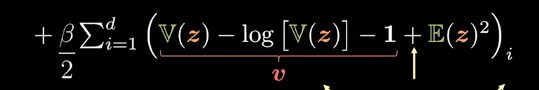
https://youtu.be/7Rb4s9wNOmc?t=1411

In [38]:
z_mean = torch.FloatTensor([2.0])
z_var = torch.FloatTensor([30.0])
z_log_var = torch.log(z_var)

In [ ]:
epochs = 10
codes = dic(/mu)

In [56]:
p = [.1, .2, .4, .2, .1]
q = [.4, .2, .2, .1, .1]

In [63]:
import numpy as np

In [64]:
def kl_divergence(p, q):
    return sum(p[i] * np.log(p[i] / q[i]) for i in range(len(p)))

In [77]:
def js_divergence(p, q):
    m = [(i + j) * .5 for i, j in zip(p, q)]
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [81]:
kl_divergence(p, p)

0.0

In [66]:
kl_divergence(p, q)

0.2772588722239781

In [67]:
kl_divergence(q, p)

0.3465735902799726

In [78]:
js_divergence(p, p)

0.0

In [79]:
js_divergence(p, q)

0.07367104477474896

In [85]:
js_divergence(q, p)

0.07367104477474896

# 05 Regression

In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

from res.plot_lib import plot_data, plot_model, set_default
import matplotlib.pyplot as plt

In [2]:
set_default()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)

N = 1000
D = 1
C = 1
H = 100 

In [5]:
X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)

y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device)

(-1.1, 1.1, -0.9548871725797653, 1.2026630252599717)

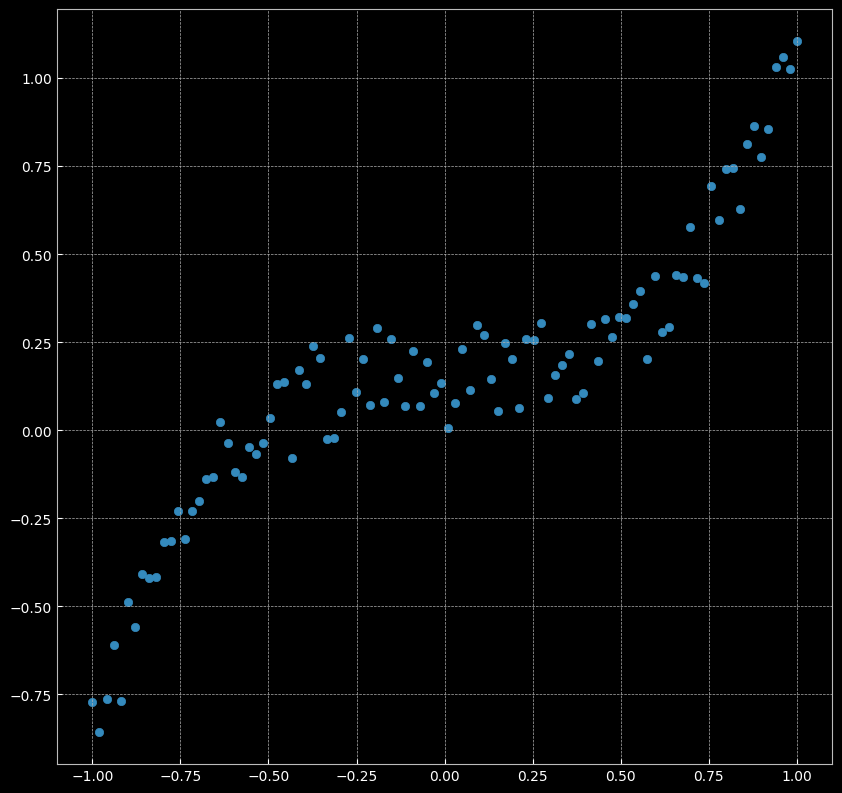

In [6]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal')

In [7]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [9]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)

In [10]:
criterion = torch.nn.MSELoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=lambda_l2
)

In [16]:
for t in range(1000):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    
    display.clear_output(wait=True)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

(-1.1, 1.1, -0.9548871725797653, 1.2026630252599717)

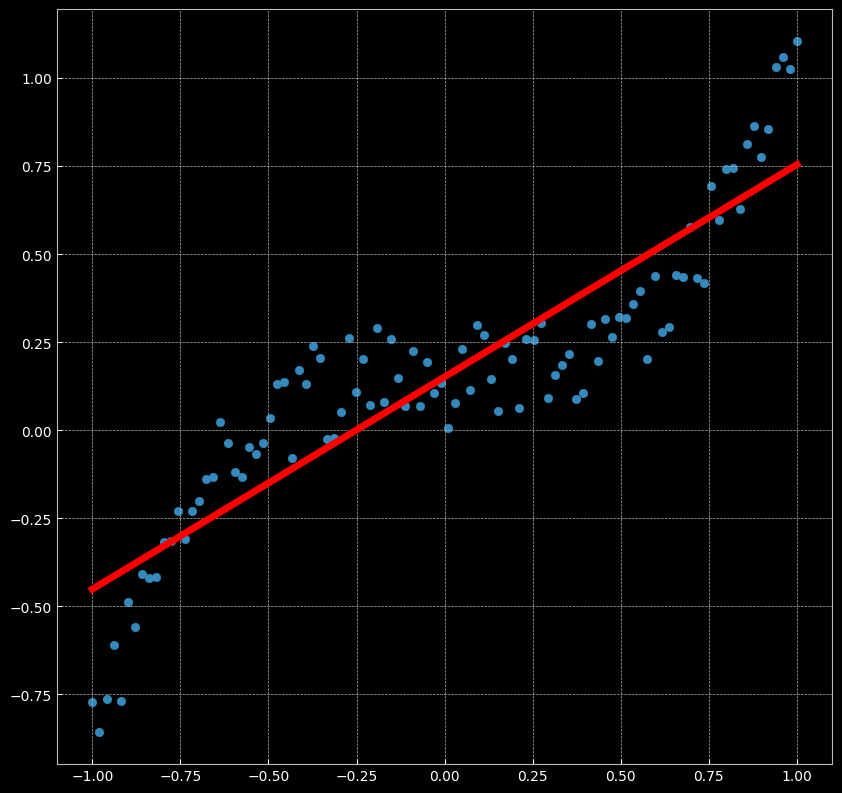

In [17]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.axis('equal')

### Two Layered Network

In [21]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [23]:
n_networks = 10
models = list()
y_pretrain = list()

criterion = torch.nn.MSELoss()

for mod in range(n_networks):
    model = nn.Sequential(
        nn.Linear(D, H),
        nn.ReLU() if mod < n_networks // 2 else nn.Tanh(),
        nn.Linear(H, C)
    )

    models.append(model)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=lambda_l2)
    for t in range(1000):
        y_pred = model(X)
        
        if t == 0:
            y_pretrain.append(y_pred.detach())
        loss = criterion(y_pred, y)
        print(f"[MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[MODEL]: 10, [EPOCH]: 999, [LOSS]: 0.008710


In [24]:
print(models[0], models[-1])

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
) Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


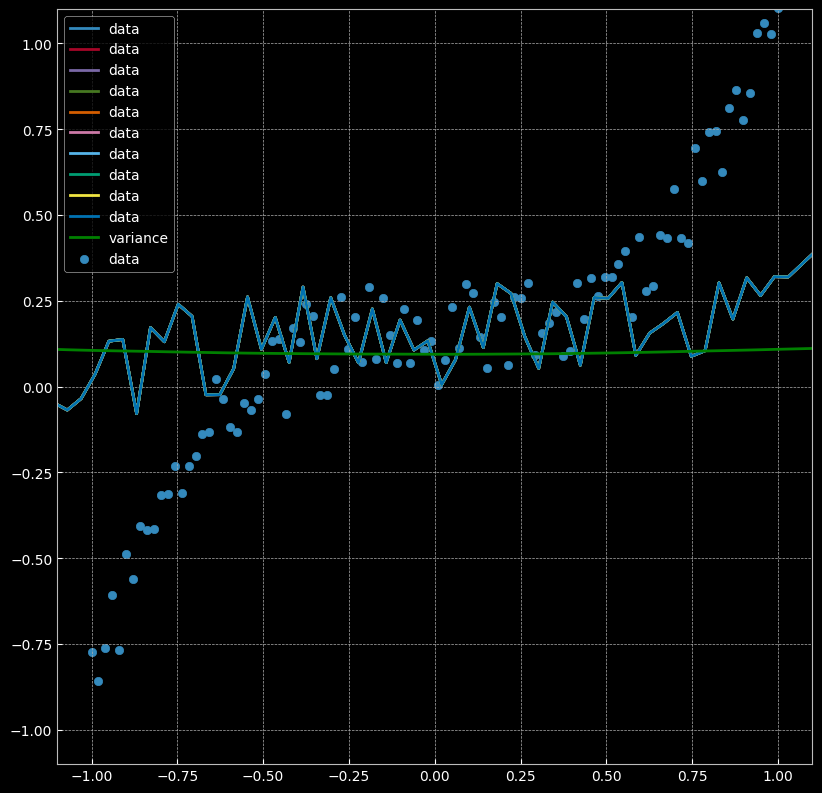

In [25]:
for y_pretrain_idx in y_pretrain:
    X_new = torch.unsqueeze(torch.linspace(-2, 2, 100), dim=1)
    
    plt.plot(X_new.numpy(), y.cpu().numpy(), label='data')
    
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
plt.axis('square')
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(X_new.numpy(), y_combo.var(dim=0).cpu().numpy(), 'g', label='variance');
plt.legend()

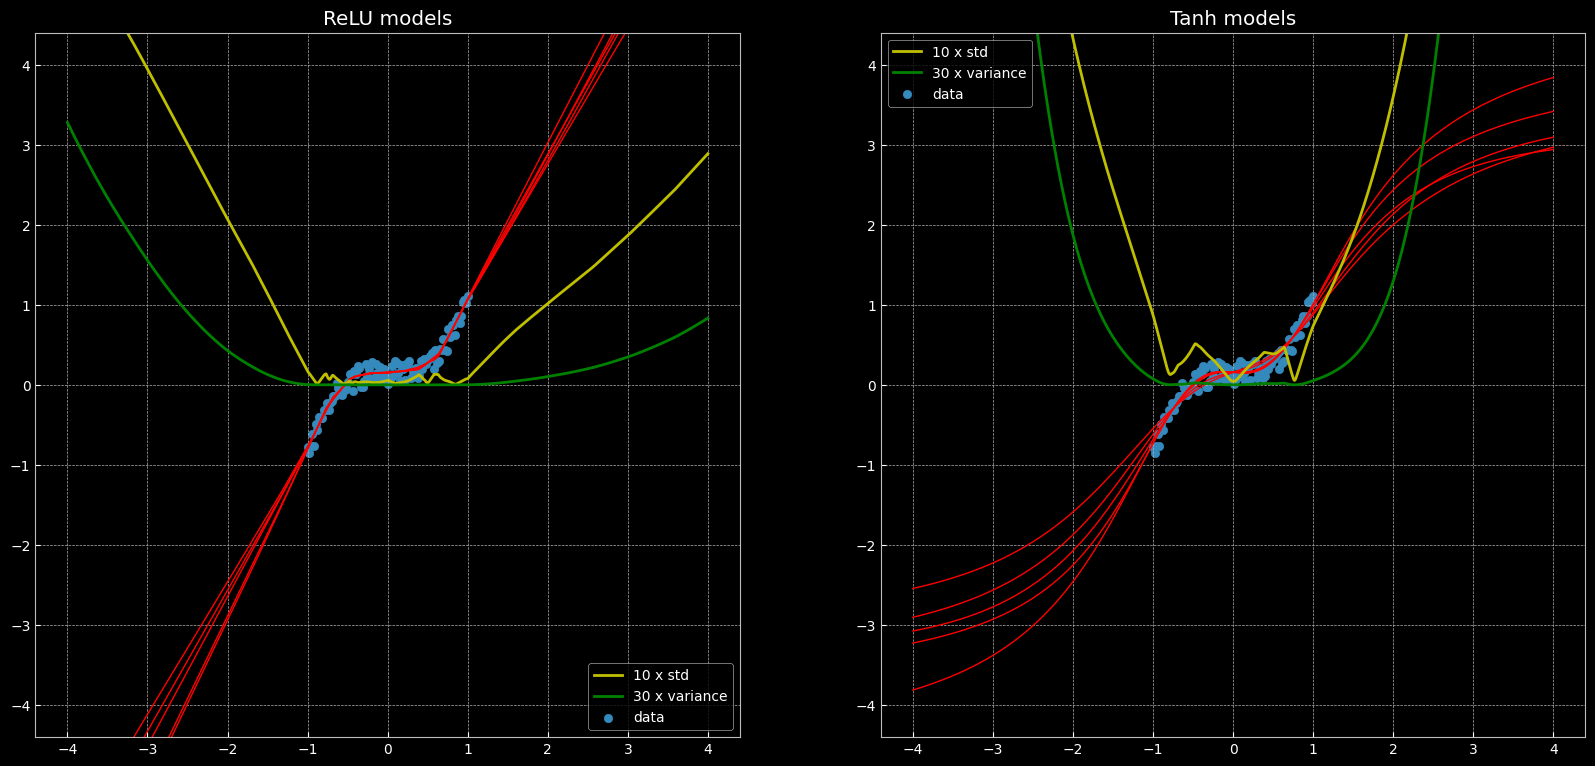

In [29]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        X_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)
        with torch.no_grad():
            y_pred.append(model(X_new))
            
        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), 'r-', lw=1)
    plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
    plt.axis('square')
    plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom)
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 x std')
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 x variance')
    plt.legend()
    plt.title(non_linearity + ' models')
    
z = 4  # try 1 to 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)

# 04 Spiral Classification

In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [2]:
from res.plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000 # Num Samples
D = 2 # Dimensions
C = 3 # Classes
H = 100 # Num Hidden

In [7]:
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

In [13]:
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    inner_var = torch.linspace(
        # when t = 0
        (2 * math.pi / C) * (c),
        # when t = 1
        (2 * math.pi / C) * (2 + c),
        N
    )
    inner_var = inner_var + torch.randn(N) * 0.2
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]),
            math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1
        
print("Shapes: ")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes: 
X: (3000, 2)
y: (3000,)


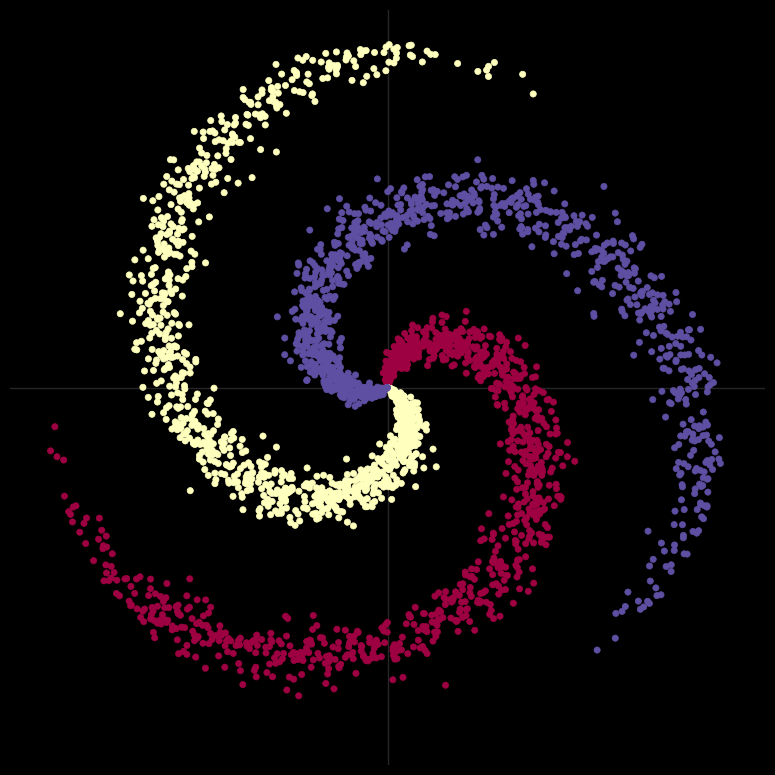

In [14]:
plot_data(X, y)

### Linear Model

In [23]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [47]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
# model = nn.Sequential(
#     nn.Linear(D, C),
# )
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=lambda_l2
)

In [60]:
for t in range(1000):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.858878, [ACCURACY]: 0.509


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


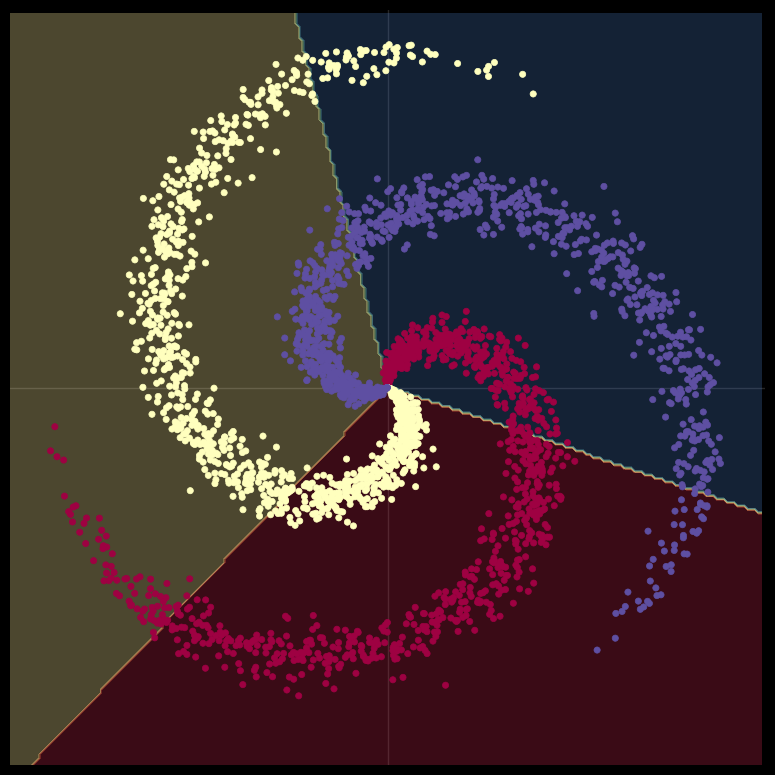

In [61]:
print(model)
plot_model(X, y, model)

###  Two-layered network

In [63]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [66]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device);

criterion = torch.nn.CrossEntropyLoss()

In [68]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=lambda_l2
)

In [136]:
for t in range(1000):
    # make predictions
    y_pred = model(X)
    # loss between predicted and actual
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.185962, [ACCURACY]: 0.948


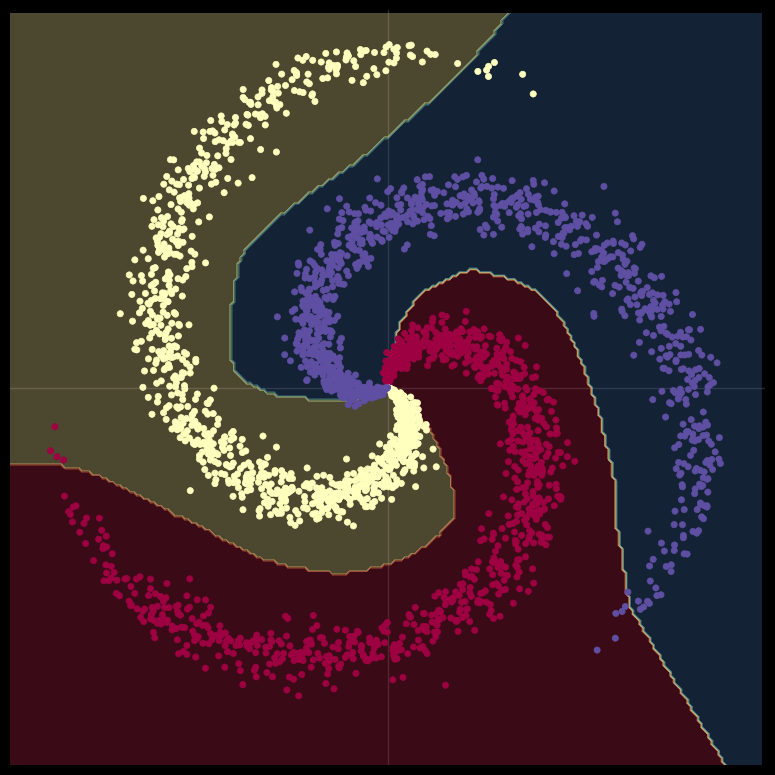

In [137]:
plot_model(X, y, model)

##### Aside on matrix multiplication

In [100]:
optimizer.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad'])

In [114]:
X.shape

torch.Size([3000, 2])

In [142]:
optimizer.param_groups[0]['params'][0].shape
H1 = optimizer.param_groups[0]['params'][0]

In [143]:
optimizer.param_groups[0]['params'][2].shape
H2 = optimizer.param_groups[0]['params'][2]

In [148]:
X.shape, H1.shape, H2.shape

(torch.Size([3000, 2]), torch.Size([100, 2]), torch.Size([3, 100]))

In [207]:
(X[200:203, :] @ H1.T @ H2.T)

tensor([[-3.4042,  0.9290,  3.7380],
        [-3.3111,  0.7890,  3.8463],
        [-3.0482,  0.4479,  4.0523]], grad_fn=<MmBackward>)

In [199]:
torch.mm(torch.mm(H1, X.T).T, H2.T).shape

torch.Size([100, 3])

In [186]:
X[0, :].reshape(-1, 1)

tensor([[-0.],
        [0.]])

#  03-Autograd

In [1]:
import torch

In [2]:
x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)

In [3]:
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [4]:
y = x - 2

In [5]:
print(y.grad_fn)

In [6]:
print(x.grad_fn)

None


In [7]:
y.grad_fn

In [8]:
y.grad_fn.next_functions

((<AccumulateGrad at 0x114055b80>, 0), (None, 0))

In [9]:
y.grad_fn.next_functions[0][0].variable

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [10]:
z = y * y * 3

In [11]:
a = z.mean()

In [12]:
print(z)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)


In [13]:
print(a)

tensor(4.5000, grad_fn=<MeanBackward0>)


In [14]:
from torchviz import make_dot

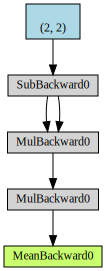

In [15]:
make_dot(a)

###  Gradients

In [16]:
a.backward()

In [17]:
print(x.grad)

tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])


In [24]:
# Dynamic graphs

In [18]:
x = torch.randn(3, requires_grad=True)

In [19]:
y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i += 1
print(y)

tensor([-564.2264,  876.3317,  166.0503], grad_fn=<MulBackward0>)


In [20]:
# backward or grad_output
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])

In [21]:
y.backward(gradients)

In [22]:
print(x.grad, i)

tensor([5.1200e+01, 5.1200e+02, 5.1200e-02]) 8


### Inference

In [116]:
n = 3

In [117]:
x = torch.arange(1., n + 1, requires_grad=True)
w = torch.ones(n, requires_grad=True)
z = w @ x

In [120]:
# Backward creates all gradients that terminated at this node.

z.backward()

tensor([1., 1., 1.])

# Scratching

In [50]:
import torch
from torch import nn
image = torch.randn(3, 10, 20)
d0 = image.nelement()

In [51]:
class mynet(nn.Module):
    def __init__(self, d0, d1, d2, d3):
        super().__init__()
        self.m0 = nn.Linear(d0, d1)
        self.m1 = nn.Linear(d1, d2)
        self.m2 = nn.Linear(d2, d3)
        
    def forward(self, x):
        z0 = x.view(-1)
        s1 = self.m0(z0)
        z1 = torch.relu(s1)
        s2 = self.m1(z1)
        z2 = torch.relu(s2)
        s3 = self.m2(z2)
        return s3

In [52]:
model = mynet(d0, 60, 40, 10)

In [61]:
out = model(image)

In [62]:
out

tensor([-0.1991, -0.1978,  0.0455,  0.3088, -0.1737, -0.1709,  0.0598,  0.1884,
         0.1106,  0.2203], grad_fn=<AddBackward0>)

# 02-Space Stretching

In [42]:
import torch
import torch.nn as nn
from res.plot_lib import set_default, show_scatterplot, plot_bases
import matplotlib.pyplot as plt

In [43]:
set_default(figsize=(3, 3))

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [82]:
n_points = 1000

X = torch.randn(n_points, 2).to(device)

In [46]:
colors = X[:, 0]

In [47]:
OI = torch.cat((torch.zeros(2, 2), torch.eye(2))).to(device)

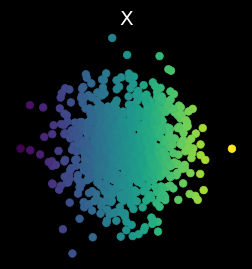

In [48]:
show_scatterplot(X, colors, title='X')

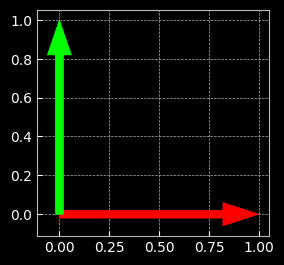

In [49]:
plot_bases(OI)

In [50]:
X.shape

torch.Size([1000, 2])

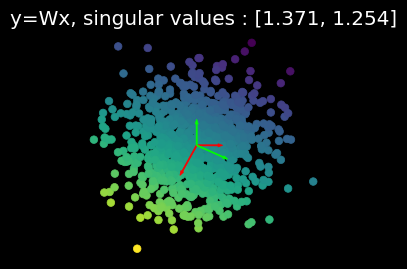

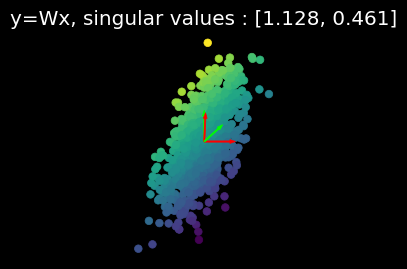

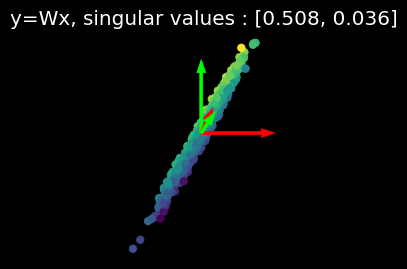

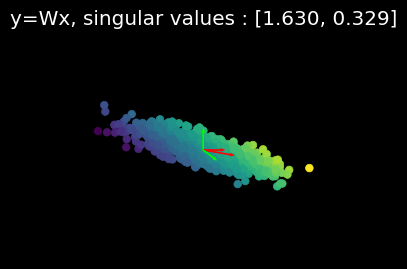

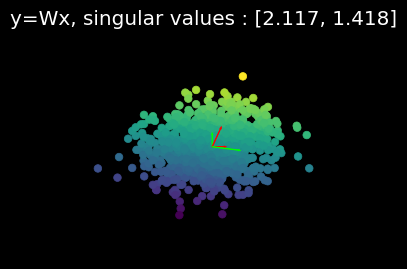

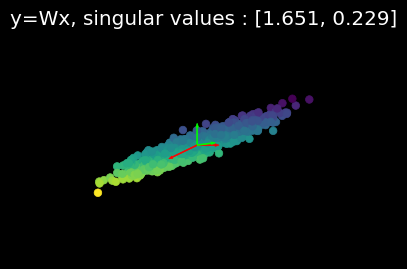

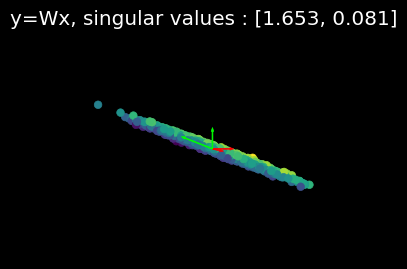

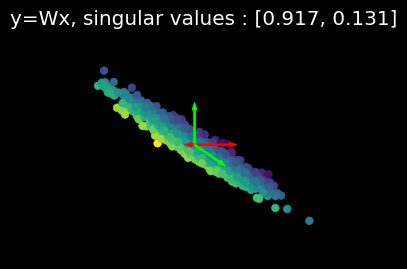

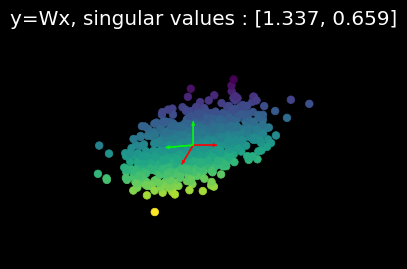

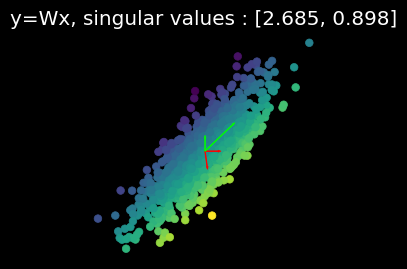

In [51]:
for i in range(10):
    W = torch.randn(2, 2).to(device)
    Y = X @ W.t()
    U, S, V = torch.svd(W)
    show_scatterplot(Y, colors, title='y=Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    new_OI = OI @ W.t()
    plot_bases(OI)
    plot_bases(new_OI)

In [52]:
W = torch.randn(2, 2).to(device)

In [53]:
W

tensor([[-0.8534, -0.9252],
        [-1.2421,  1.0528]])

### Linear Transformation with pytorch (using a model)

In [54]:
model = nn.Sequential(
    nn.Linear(2, 2, bias=False)
)
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=False)
)

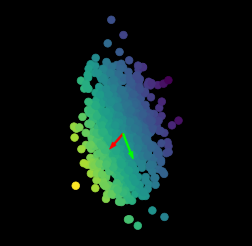

In [56]:
with torch.no_grad():
    Y = model(X)
    show_scatterplot(Y, colors)
    plot_bases(model(OI))

In [59]:
X

tensor([[-1.9557,  0.4457],
        [ 1.2937,  1.4778],
        [ 0.3432,  0.7525],
        ...,
        [-0.7031,  0.2213],
        [ 0.4000,  1.5002],
        [ 0.3554,  1.6849]])

### Non-linear transformations
Linear transformations cannot curve through space. 

We need to apply non linearities to achieve this. 

In [60]:
z = torch.linspace(-10, 10, 100)

In [61]:
s = torch.tanh(z)

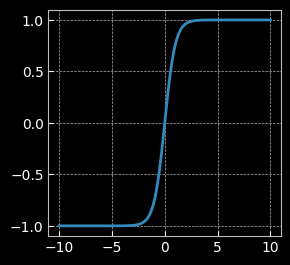

In [63]:
plt.plot(z.numpy(), s.numpy())

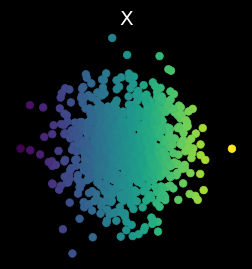

In [64]:
show_scatterplot(X, colors, title='X')

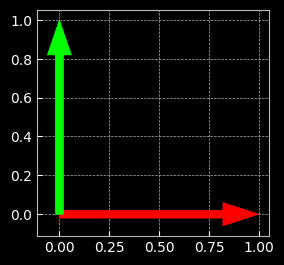

In [65]:
plot_bases(OI)

In [66]:
model=nn.Sequential(
    nn.Linear(2, 2, bias=False),
    nn.Tanh()
)
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=False)
  (1): Tanh()
)

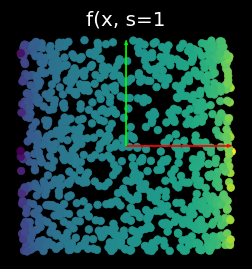

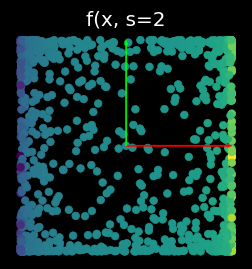

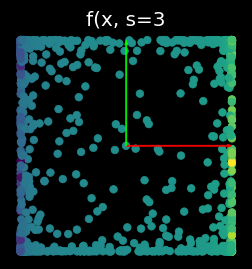

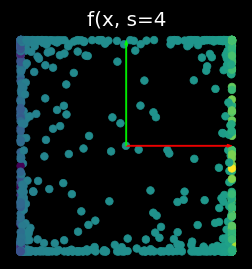

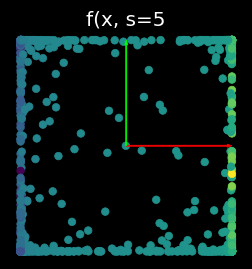

In [76]:
for s in range(1, 6):
    W = s * torch.eye(2)
    model[0].weight.data.copy_(W)
    Y = model(X).data
    show_scatterplot(Y, colors, title=f'f(x, s={s}')
    plot_bases(OI, width=0.01)

### Visualize Functions represented by random neural nets

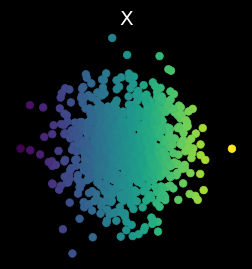

In [79]:
show_scatterplot(X, colors, title='X')
n_hidden = 5

In [78]:
NL = nn.Tanh()

### 2 X 5 X 2 network

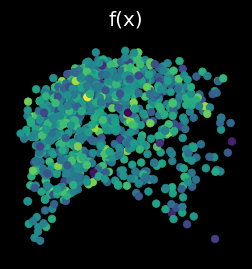

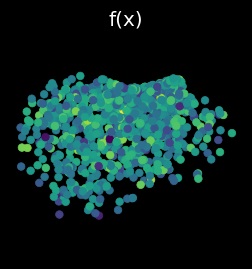

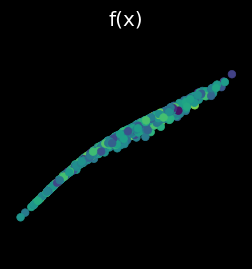

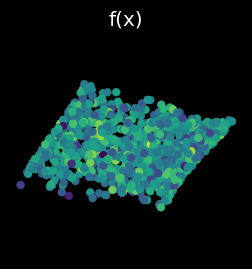

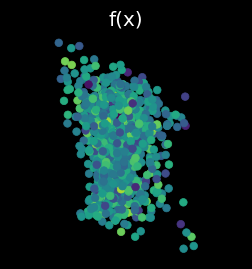

In [83]:
for i in range(5):
    model = nn.Sequential(
        nn.Linear(2, n_hidden),
        NL,
        nn.Linear(n_hidden, 2)
    )
    model.to(device)
    with torch.no_grad():
        Y = model(X)
    show_scatterplot(Y, colors, title='f(x)')

### 2 x 5 x 5 x 5 x 2 network

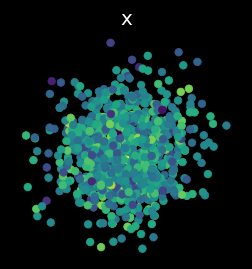

In [84]:
show_scatterplot(X, colors, title='x')
n_hidden = 5

In [85]:
NL = nn.Tanh()

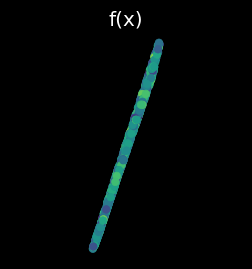

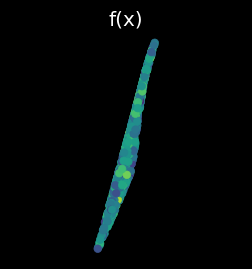

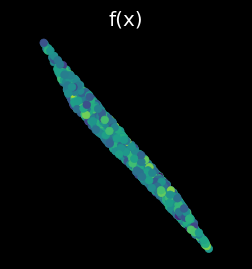

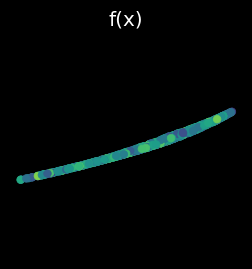

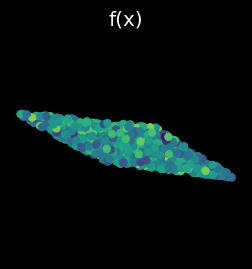

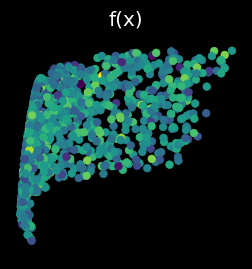

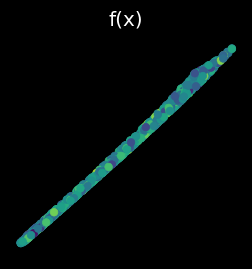

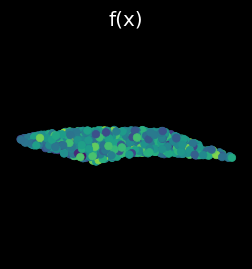

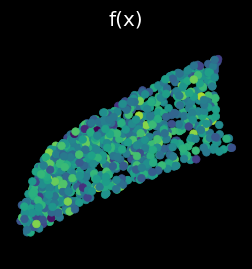

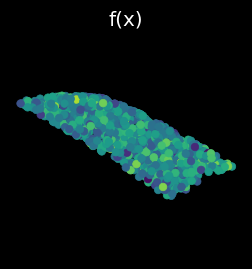

In [94]:
X = torch.rand(1000, 2)
for i in range(100):
    model = nn.Sequential(
        nn.Linear(2, n_hidden),
        NL,
        nn.Linear(n_hidden, n_hidden),
        NL,
        nn.Linear(n_hidden, n_hidden),
        NL,
        nn.Linear(n_hidden, n_hidden),
        NL,
        nn.Linear(n_hidden, 2)
    )
    model.to(device)
#     with torch.no_grad():
#         Y = model(X).detach()
    Y = model(X).detach()
    if i % 10 == 0:
        show_scatterplot(Y, colors, title='f(x)')

# 01-tensor tutorial

In [1]:
import torch

In [5]:
t = torch.Tensor(2, 3, 4)

In [6]:
t.size()

torch.Size([2, 3, 4])

In [7]:
t.random_(10)

tensor([[[4., 0., 6., 1.],
         [0., 3., 4., 9.],
         [6., 6., 4., 2.]],

        [[3., 0., 8., 6.],
         [2., 5., 9., 1.],
         [7., 5., 1., 6.]]])

In [8]:
r = torch.Tensor(t)

##### Vectors(1D Tensors)

In [19]:
v = torch.Tensor([1, 2, 3, 4])

In [20]:
w = torch.Tensor([1, 0, 2, 0])

In [22]:
w @ v

tensor(7.)

In [27]:
v * w

tensor([1., 0., 6., 0.])

In [160]:
x = torch.Tensor(5).random_(10)

In [161]:
x[1:2 + 1]

tensor([6., 2.])

# 00

In [162]:
import torch

import numpy as np
import matplotlib.pyplot as plt

In [163]:
a = np.array([[0, 0]])
b = np.array([[0, 1]])
c = np.array([[1, 1]])
d = np.array([[1, 0]])

In [164]:
a = np.array([[0, 1, 1, 0],
              [0, 1, 0, 1]])

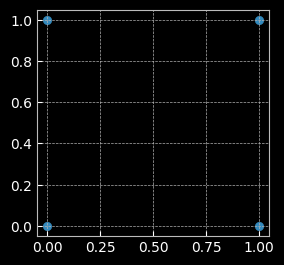

In [165]:
plt.scatter(a[0], a[1])

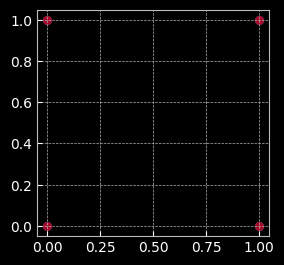

In [166]:
w = np.array(
    [[1, 0],
     [0, 1]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

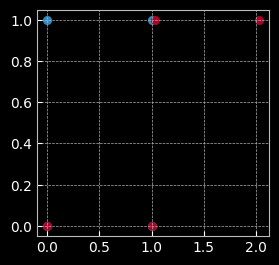

In [167]:
w = np.array(
    [[1, 1.03],
     [0, 1]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

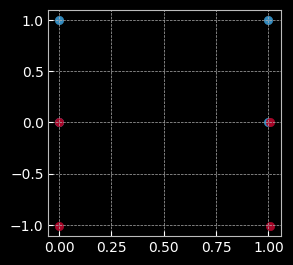

In [168]:
w = np.array(
    [[0, 1.01],
     [-1.01, 0]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

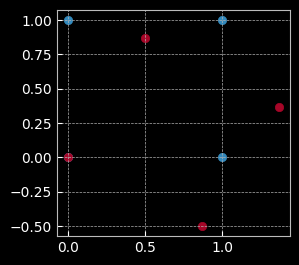

In [169]:
rad = -30/360 * 2 * np.pi
w = np.array(
    [[np.cos(rad), -np.sin(rad)],
     [np.sin(rad), np.cos(rad)]]
)
res = np.dot(w, a)
plt.scatter(a[0], a[1])
plt.scatter(res[0], res[1])

# Playing with translation and rotation

(-5.0, 5.0)

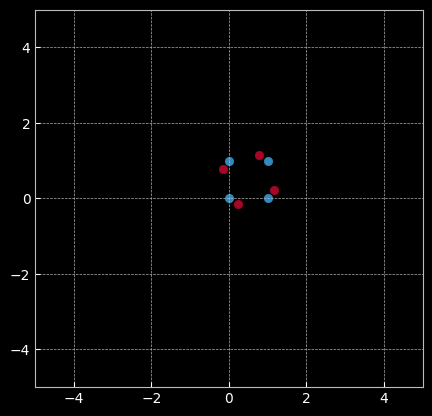

In [170]:

# w = np.array(
#     [[np.cos(rad), -np.sin(rad)],
#      [np.sin(rad), np.cos(rad)]]
# )
plt.figure(figsize=(5, 5))
t = np.append(a, np.ones((1, a.shape[1])), axis=0)
x_trans = 0
y_trans = 0
trans = np.array([
    [1, 0, -.5],
    [0, 1, -.5],
    [0, 0, 1]
])
rad = .4
rotate = np.array([
    [np.cos(rad), -np.sin(rad), 0],
    [np.sin(rad),  np.cos(rad), 0],
    [          0,            0, 1]
])
inv_trans = np.array([
    [1, 0, .5],
    [0, 1, .5],
    [0, 0, 1]
])
res = inv_trans.dot(rotate.dot(trans.dot(t)))
# another = inv_trans.dot(rotate.dot(trans.dot(t)))
plt.scatter(t[0], t[1])
plt.scatter(res[0], res[1])
# plt.scatter(another[0] + .01, another[1] + .01)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Eigen Values and SVD

In [137]:
a = np.array([
    [2, 2],
    [-2, 1]
])

In [138]:
vals, vecs = np.linalg.eig(a)

vecs

array([[ 0.70710678+0.j       ,  0.70710678-0.j       ],
       [-0.1767767 +0.6846532j, -0.1767767 -0.6846532j]])

In [140]:
one = vecs[:, 0]

In [141]:
two = vecs[:, 1]

In [142]:
one.dot(two)

(0.9999999999999998+0j)

In [158]:
one.conjugate().dot(two)

(0.06250000000000017+0.24206145913796373j)

/Users/rglamber/repos/pytorch-Deep-Learning/.env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


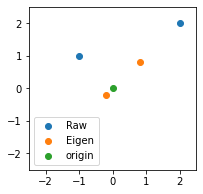

In [30]:
plt.figure(figsize=(3, 3))
plt.scatter(a[:, 0], a[:, 1], label='Raw')
plt.scatter(vecs[:, 0], vecs[:, 1], label='Eigen')
plt.scatter([0], [0], label='origin')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.legend()